## Quantitative Portfolio Management Final Project
### Group 4

Code for the Group 4 final project leveraging code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and Federico Mainardi.

In [1]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [2]:
_DATA_DIR = 'C:/Users/natha/Documents/Python/QPM/Final_Project/Data'

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [3]:
#Full strategy with Safety
_STRATEGY_NAME = 'EMQ'    

#Strategy with only Profitability
#_STRATEGY_NAME = 'EMQ-S'    

_SORT_FREQUENCY = 'June'        # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = True      # Either "True" or "False"
_SAMPLE_START = '2001-01-01'
_SAMPLE_END = '2023-07-31'
_NUM_PORT = 5

### Step 1. Construct Signal

In [4]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'gvkey', 'conm', 'cusip', 'lpermco']

Prices and Returns:
['ret', 'retx', 'prc', 'prcc_c', 'prcc_f', 'vwretd', 'ewretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', 'xacc', 'xad', 'xint

#### Load Data

In [5]:
df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables

We first list the columns in our data

In [6]:
print(df_full.columns)

Index(['permno', 'ret', 'retx', 'vol', 'shrout', 'prc', 'cfacshr', 'bidlo',
       'askhi', 'shrcd',
       ...
       'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity',
       'ldate_lag', 'screen', 'ldate_lag12', 'screen12', 'me_lagged'],
      dtype='object', length=170)


In [7]:
print(df_full.columns.tolist())

['permno', 'ret', 'retx', 'vol', 'shrout', 'prc', 'cfacshr', 'bidlo', 'askhi', 'shrcd', 'exchcd', 'sicCRSP', 'ticker', 'shrcls', 'comnam', 'sic2D', 'ldate', 'mve_c', 'gvkey', 'datadate', 'conm', 'fyear', 'tic', 'cusip', 'naicsh', 'sich', 'aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'ceq', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prcc_c', 'prcc_f', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', '

In [8]:
df_full

,permno,ret,retx,vol,shrout,prc,cfacshr,bidlo,askhi,shrcd,...,ESG_score,E_score,S_score,G_score,carbon_intensity,ldate_lag,screen,ldate_lag12,screen12,me_lagged
0,10001,0.006957,-0.004348,0.0478,2.566,11.450000,1.5,11.120000,11.500000,11,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN
1,10001,-0.013100,-0.013100,0.0474,2.566,11.300000,1.5,11.100000,11.500000,11,...,NaN,NaN,NaN,NaN,NaN,2001-12-01,1.0,NaT,NaN,29.380699
2,10001,-0.053097,-0.053097,0.0495,2.569,10.700000,1.5,10.506000,11.249000,11,...,NaN,NaN,NaN,NaN,NaN,2002-01-01,1.0,NaT,NaN,28.995800
3,10001,-0.015888,-0.028037,0.0908,2.571,10.400000,1.5,10.160000,11.000000,11,...,NaN,NaN,NaN,NaN,NaN,2002-02-01,1.0,NaT,NaN,27.488300
4,10001,-0.043269,-0.043269,0.1346,2.571,9.950000,1.5,9.870000,10.497500,11,...,NaN,NaN,NaN,NaN,NaN,2002-03-01,1.0,NaT,NaN,26.738400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074184,93436,0.008507,0.008507,3311.5078,3169.314,207.460007,1.0,172.919998,207.460007,11,...,NaN,NaN,NaN,NaN,NaN,2023-02-01,1.0,2022-03-01,1.0,650887.625000
1074185,93436,-0.207992,-0.207992,2503.8244,3169.504,164.309998,1.0,153.750000,194.770004,11,...,NaN,NaN,NaN,NaN,NaN,2023-03-01,1.0,2022-04-01,1.0,657505.875000
1074186,93436,0.241130,0.241130,2681.6033,3169.504,203.929993,1.0,160.309998,203.929993,11,...,NaN,NaN,NaN,NaN,NaN,2023-04-01,1.0,2022-05-01,1.0,520781.187500
1074187,93436,0.283627,0.283627,3440.9322,3174.000,261.769989,1.0,207.520004,274.450012,11,...,NaN,NaN,NaN,NaN,NaN,2023-05-01,1.0,2022-06-01,1.0,646356.937500


### Write functions to calculate the first component of the Quality Minus Junk - Profit

In [9]:
def calculate_gp_margin_assets_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate average growth in assets (at) over the last year for each row excluding future dates
    df['gp_margin_assets'] = ((df['revt'] - df['cogs']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the at_growth column, handling NaN values explicitly
    df['gp_margin_assets_z_score'] = df.groupby('ldate')['gp_margin_assets'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [10]:
def calculate_ni_be_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['ni_be'] = (df['ni'] / df['be']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['ni_be_z_score'] = df.groupby('ldate')['ni_be'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [11]:
def calculate_ni_at_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['ni_at'] = (df['ni'] / df['at']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['ni_at_z_score'] = df.groupby('ldate')['ni_at'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [12]:
def calculate_ocf_at_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['ocf_at'] = (df['oancf'] / df['at']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['ocf_at_z_score'] = df.groupby('ldate')['ocf_at'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [13]:
def calculate_gp_margin_sales_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['gp_margin_sales'] = ((df['revt'] - df['cogs']) / df['revt']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['gp_margin_sales_z_score'] = df.groupby('ldate')['gp_margin_sales'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [14]:
def calculate_oa_at_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['operatingaccurals'] = ((df['ni'] - df['oancf']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['oa_at_zscore'] = df.groupby('ldate')['operatingaccurals'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)


In [15]:
def calculate_beta_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Set conditions for variables to be missing
    df.loc[df['beta'].isnull(), 'beta_z_score'] = np.nan

    # Calculate z-score for beta using zscore within each unique date
    df['beta_z_score'] = df.groupby('ldate')['beta'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [16]:
def calculate_debt_at_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Calculate net income scaled by book equity (ni/be) for each row excluding future dates
    df['debt_to_assets'] = ((df['dltt'] + df['dlc']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the ni/be column, handling NaN values explicitly
    df['debt_to_assets_z_score'] = df.groupby('ldate')['debt_to_assets'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [17]:
def calculate_oscore_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Set conditions for variables to be missing
    df.loc[df['at'] <= 0, ['o_lat', 'o_lev', 'o_wc', 'o_roe']] = np.nan
    df.loc[df['act'] <= 0, 'o_cacl'] = np.nan
    df.loc[df['lt'] <= 0, 'o_ffo'] = np.nan
    df.loc[(df['lt'].isnull()) | (df['at'].isnull()), 'o_neg_eq'] = np.nan
    df.loc[(df['ni'].isnull()) | (df['ni'].shift(12).isnull()) | (df['at'].isnull()), ['o_nich', 'o_neg_earn']] = np.nan

    # Calculate helper variables
    df['o_lat'] = np.log(df['at'].shift(1) + 1e-8)  # Add a small constant before taking the log
    df['o_lev'] = ((df['dltt'] + df['dlc']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['o_wc'] = ((df['act'] - df['lct']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['o_roe'] = (df['ni'] / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['o_calc'] = (df['lct'] / df['act']).where(df['ldate'] <= df['ldate'].cummax())
    df['o_ffo'] = ((df['pi'] + df['dp']) / df['lt']).where(df['ldate'] <= df['ldate'].cummax())
    df['o_neg_eq'] = np.where(df['lt'] > df['at'], 1, 0)
    df['o_neg_earn'] = np.where((df['ni'] < 0) & (df['ni'].shift(12) < 0), 1, 0)
    df['o_nich'] = (df['ni'] - df['ni'].shift(12)) / (abs(df['ni']) + abs(df['ni'].shift(12)))

    # Coefficients for the Ohlson O-Score
    coefficients = {
        'o_lat': -0.407,
        'o_lev': 6.03,
        'o_wc': 1.43,
        'o_roe': -2.37,
        'o_calc': 0.076,
        'o_ffo': 1.83,
        'o_neg_eq': -1.72,
        'o_neg_earn': 0.285,
        'o_nich': -0.52
    }

    # Calculate o_score with -1.37 constant term
    df['o_score'] = -1.37 + sum(df[ratio] * coefficients[ratio] for ratio in coefficients).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the o_score column within each date, handling NaN values explicitly
    df['o_score_z_score'] = df.groupby('ldate')['o_score'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x
    )


In [18]:
def calculate_altman_zscore(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Set conditions for variables to be missing
    df.loc[df['at'] <= 0, ['z_wc', 'z_re', 'z_eb', 'z_me', 'z_sa']] = np.nan
    df.loc[df['lt'] <= 0, 'z_me'] = np.nan

    # Calculate helper variables
    df['z_wc'] = ((df['act'] - df['lct']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['z_re'] = (df['re'] / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['z_eb'] = ((df['ebit'] + df['dp']) / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['z_sa'] = (df['revt'] / df['at']).where(df['ldate'] <= df['ldate'].cummax())
    df['z_me'] = (df['me'] / df['lt']).where(df['ldate'] <= df['ldate'].cummax())

    # Coefficients for the Altman Z-Score
    coefficients = {
        'z_wc': 1.2,
        'z_re': 1.4,
        'z_eb': 3.3,
        'z_me': 0.6,
        'z_sa': 1.0
    }

    # Calculate z_score
    df['raw_altman_score'] = sum(df[ratio] * coefficients[ratio] for ratio in coefficients).where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the z_score column, handling NaN values explicitly
    df['altman_zscore_z_score'] = df.groupby('ldate')['raw_altman_score'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)

In [19]:
def calculate_roe_volatility(df):
    # Sort the DataFrame by date in ascending order
    df.sort_values(by='ldate', inplace=True)

    # Set conditions for variables to be missing
    df.loc[(df['ni'].isnull()) | (df['be'].isnull()), 'roe_volatility'] = np.nan

    # Calculate ROE Volatility
    df['roe_vol'] = (df['ni'] / df['be']).rolling(window=60, min_periods=1).std().where(df['ldate'] <= df['ldate'].cummax())

    # Compute the z-score for the roe_volatility column, handling NaN values explicitly
    df['roe_vol_z_score'] = df.groupby('ldate')['roe_vol'].transform(lambda x: (x - x.mean()) / x.std() if x.notnull().all() else x)


In [20]:
#Profit Scores
calculate_gp_margin_assets_zscore(df_full)
calculate_ni_be_zscore(df_full)
calculate_ni_at_zscore(df_full)
calculate_ocf_at_zscore(df_full)
calculate_gp_margin_sales_zscore(df_full)
calculate_oa_at_zscore(df_full)

#Safety Scores
calculate_beta_zscore(df_full)
calculate_debt_at_zscore(df_full)
calculate_oscore_zscore(df_full)
calculate_altman_zscore(df_full)
calculate_roe_volatility(df_full)

In [21]:
# Select the columns you want to sum and z-transform
profit_columns_to_sum = ['gp_margin_assets_z_score','ni_be_z_score','ni_at_z_score','ocf_at_z_score','gp_margin_sales_z_score','oa_at_zscore']
safety_columns_to_sum = ['debt_to_assets_z_score','o_score_z_score','altman_zscore_z_score','roe_vol_z_score','beta_z_score']

quality_dict = {'profit': profit_columns_to_sum,
                'safety': safety_columns_to_sum
}

In [22]:
#For loop to sum the columns making up each component and calculate a z-score
for i in quality_dict:
    column_name = i + "_sum"
    
    #Calculate a sum for each of the quality components
    df_full[column_name] = df_full[quality_dict[i]].sum(axis=1)
    
    #Drop NA & Infinite values
    df_full.dropna(subset=[column_name], inplace=True)
    df_full[column_name].replace([np.inf, -np.inf], np.nan, inplace=True)
        
    #Create a new z-score column
    column_name_2 = i + "_zscore"   
    
    #Use StandardScaler for z-transformation on the sum
    scaler = StandardScaler()
    df_full[column_name_2] = scaler.fit_transform(df_full[[column_name]])

Next, we plot a variable of interest, such as in this case a stock's market capitalization.

gp_margin_assets_z_score


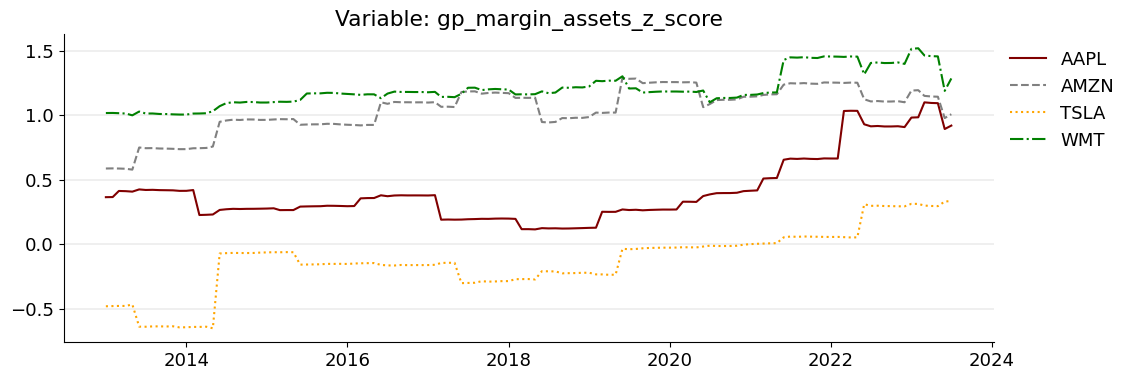

ni_be_z_score


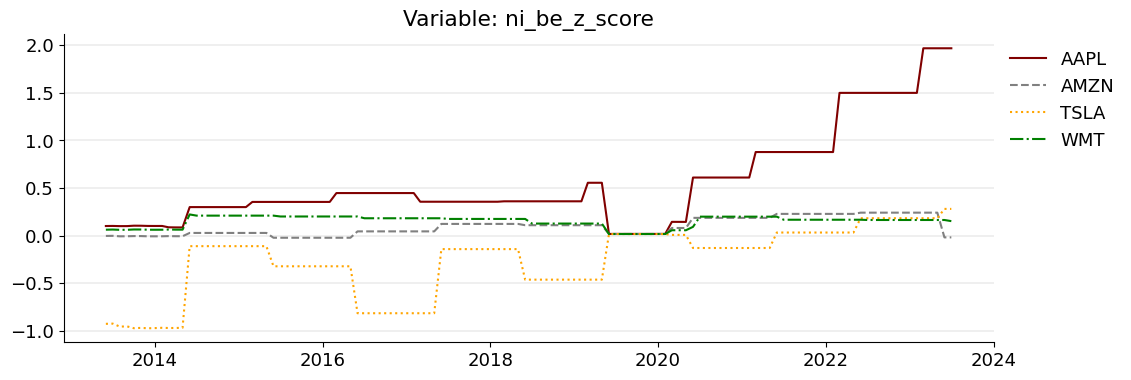

ni_at_z_score


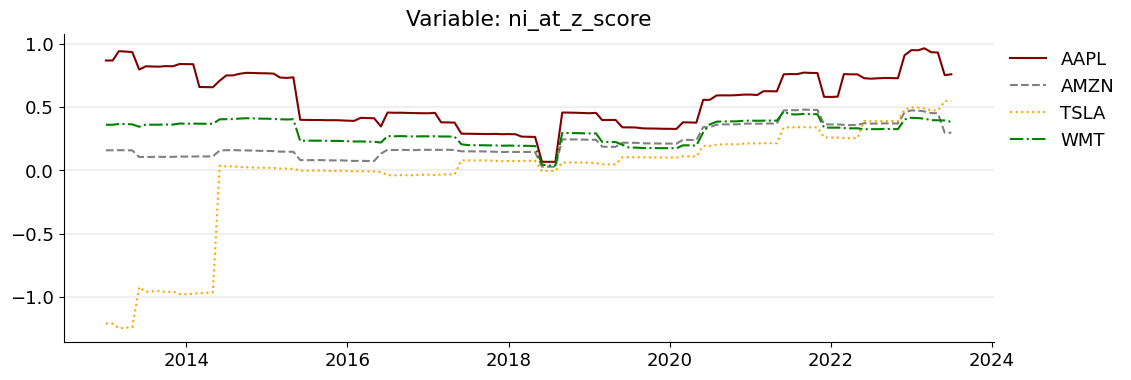

ocf_at_z_score


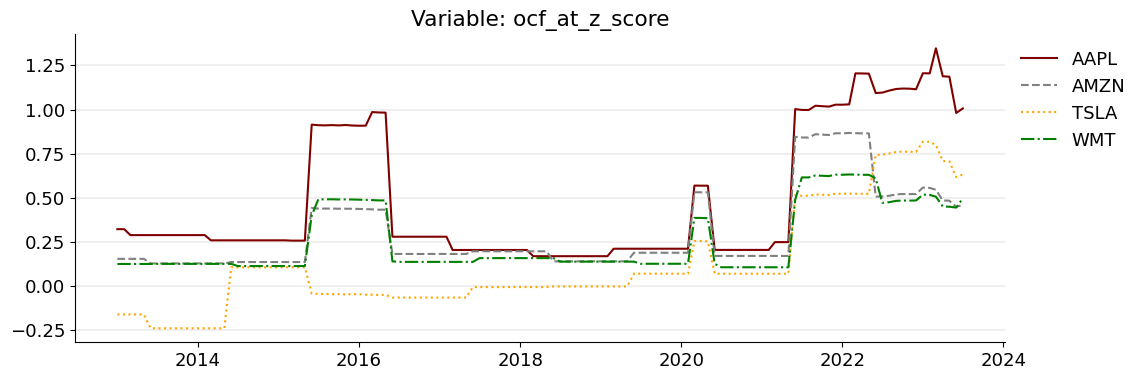

gp_margin_sales_z_score


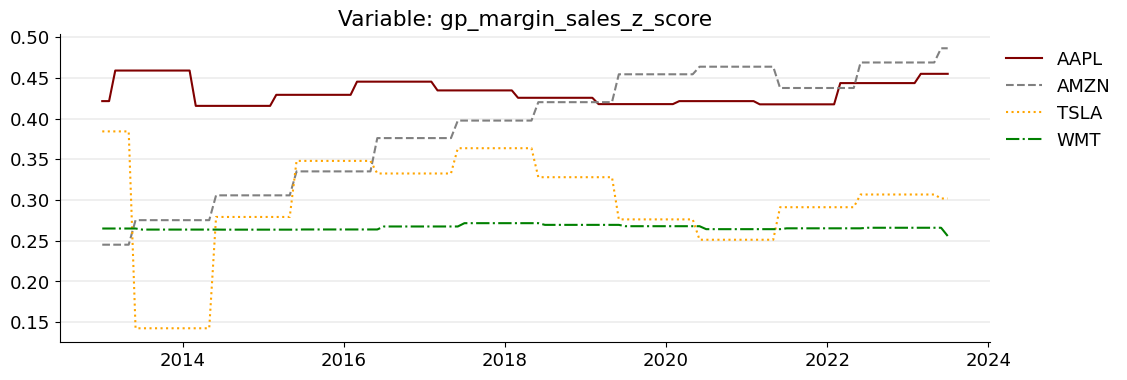

oa_at_zscore


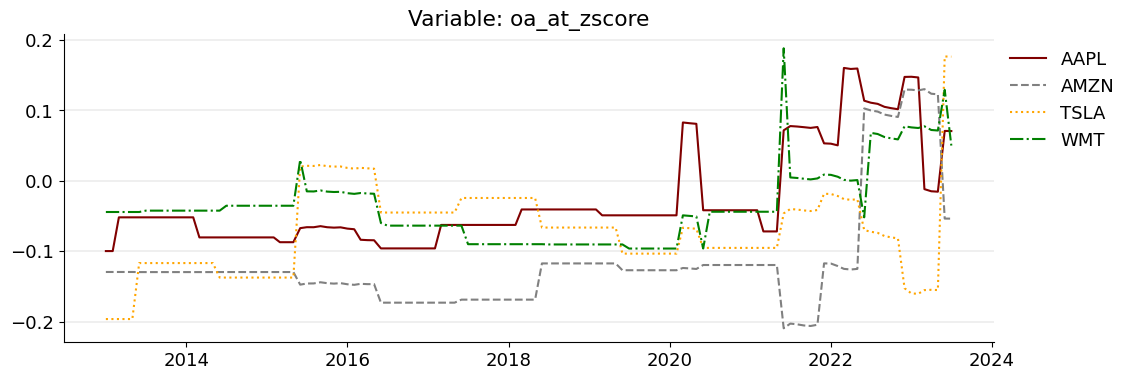

debt_to_assets_z_score


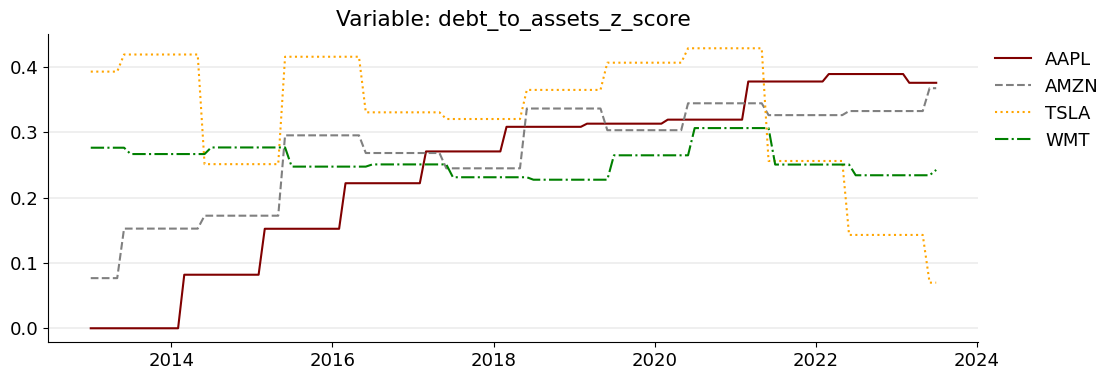

o_score_z_score


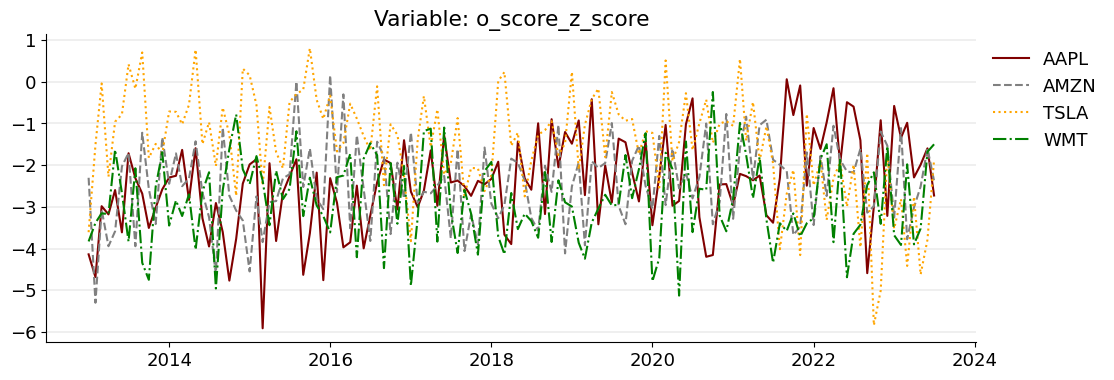

altman_zscore_z_score


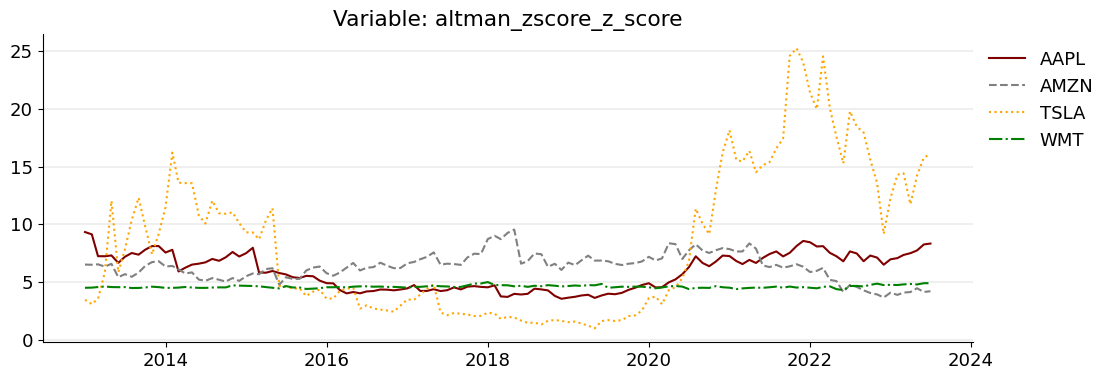

roe_vol_z_score


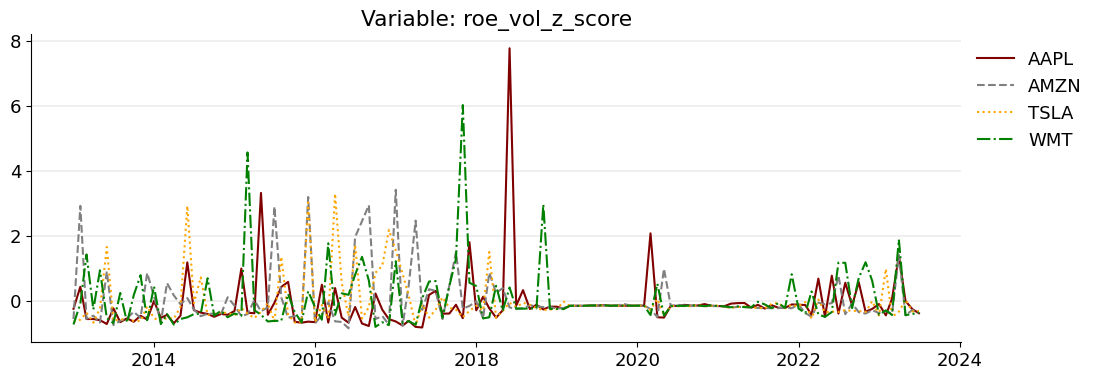

beta_z_score


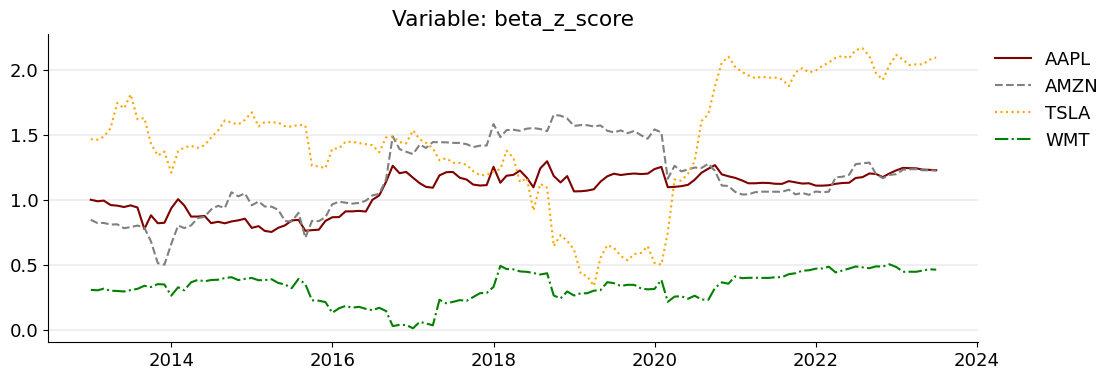

In [23]:
#View individual graphs
for i in quality_dict:
    for j in quality_dict[i]:
        print(j)
        column_name = j

        qpm.plot_variables(df_full, variable_list = [column_name],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA','WMT'],
                         start_date = '2013-01-01', end_date = '2023-07-31')

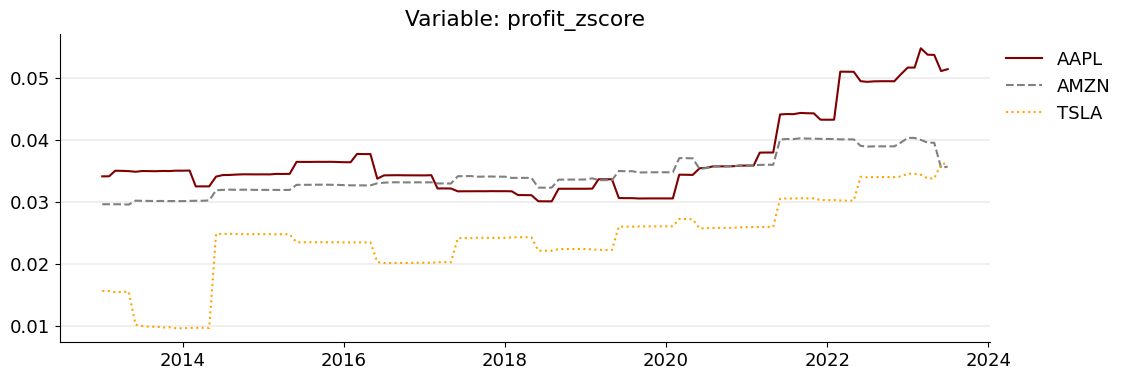

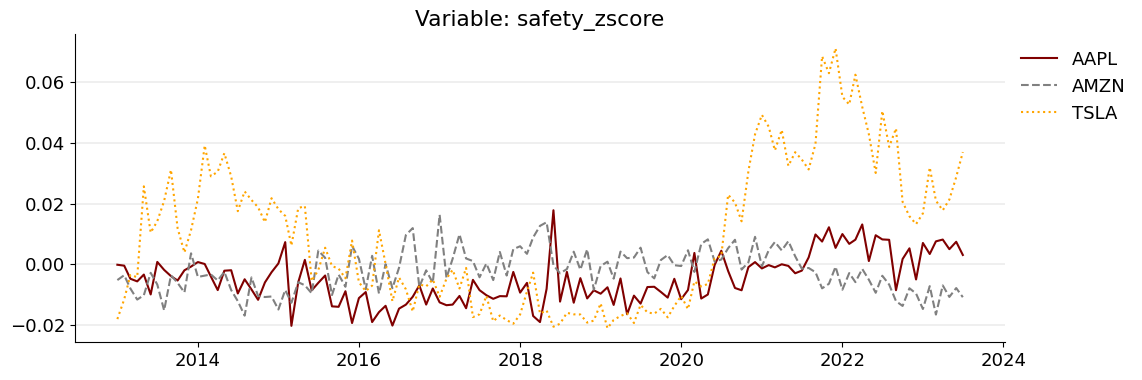

In [24]:
for i in quality_dict:
    column_name = i + "_zscore"
    
    qpm.plot_variables(df_full, variable_list = [column_name],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '2013-01-01', end_date = '2023-07-31')

In [25]:
df_full

,permno,ret,retx,vol,shrout,prc,cfacshr,bidlo,askhi,shrcd,...,z_sa,raw_altman_score,altman_zscore_z_score,roe_volatility,roe_vol,roe_vol_z_score,profit_sum,profit_zscore,safety_sum,safety_zscore
516106,78956,-0.206780,-0.206780,0.6155,8.367,14.040000,2.250000,13.680000,15.400000,11,...,2.290291,5.207423,0.091947,NaN,NaN,NaN,2.704492,0.038422,-0.893741,-0.025399
516343,78963,0.252773,0.252773,10.1383,26.625,37.270000,6.000000,26.799999,37.270000,11,...,2.202297,23.014139,4.308854,NaN,0.132112,0.132112,5.467256,0.052894,3.594133,-0.008912
639591,83391,-0.137931,-0.137931,0.0787,8.895,1.250000,1.000000,1.210000,1.450000,11,...,0.666945,-1.161734,-1.416368,NaN,0.162967,0.162967,0.240381,0.025515,-0.282658,-0.023154
229063,21055,-0.031250,-0.031250,5.7910,21.975,32.549999,1.000000,27.700001,33.500000,11,...,1.931395,5.274449,0.107820,NaN,0.136937,0.136937,2.824246,0.039049,0.612231,-0.019866
568382,80544,0.020202,0.020202,0.3406,5.956,5.050000,3.515625,4.550000,6.030000,11,...,2.318637,3.522733,-0.307014,NaN,0.122468,0.122468,2.986014,0.039897,-0.871335,-0.025316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177624,16784,0.091933,0.091933,0.6243,8.190,49.945000,1.000000,43.529999,51.750000,11,...,0.061562,0.445095,0.445095,NaN,3.217347,-0.296626,1.652732,0.032913,1.032209,-0.018323
211342,19145,0.237868,0.237868,12.6595,48.047,57.139999,1.000000,46.360001,57.139999,11,...,0.863596,10.535070,10.535070,NaN,3.217730,-0.296611,1.811030,0.033742,6.754799,0.002699
364207,59248,0.059690,0.059690,41.8509,210.954,69.769997,1.000000,64.440002,70.669998,11,...,0.413672,1.595890,1.595890,NaN,3.217781,-0.296609,1.047544,0.029743,0.098832,-0.021752
180307,16920,0.019669,0.019669,0.1546,10.468,9.850000,1.000000,9.540000,10.380000,11,...,1.647896,2.978649,2.978649,NaN,3.203374,-0.297169,1.959457,0.034520,1.276190,-0.017427


#### Construct Signal

In [26]:
if _STRATEGY_NAME == 'EMQ':

    # Signal 1 : Rank Momentum
    # Sort data
    df_full.sort_values(['permno', 'ldate'], ascending = [True, True], inplace = True)      
    
    #create a mask
    mask = df_full['epspx'] != df_full.groupby('ticker')['epspx'].shift(12)
    
    #Calculate the percentage change using the mask
    df_full['percentage_change'] = df_full.groupby('ticker')['epspx'].pct_change().where(mask).groupby(df_full['ticker']).ffill()*100
    
    df_full['signal_1'] = df_full['percentage_change']
    
    #Rank based on signal
    df_full['signal_1'] = qpm.rank(df_full, var_name = 'signal_1')
    
    
    # Signal 2 : Rank Quality   
    df_full['quality_signal'] = (df_full['profit_zscore'] + df_full['safety_zscore'])/2
    
    df_full['signal_2'] = qpm.rank(df_full, var_name = 'quality_signal')
    
    # Final Signal: Combine the two signals 
    df_full['signal'] = ((df_full['signal_1'] + df_full['signal_2'])/2)
    

elif _STRATEGY_NAME == 'EMQ-S':

    # Signal 1 : Rank Momentum
    # Sort data
    df_full.sort_values(['permno', 'ldate'], ascending = [True, True], inplace = True)      
    
    #create a mask
    mask = df_full['epspx'] != df_full.groupby('ticker')['epspx'].shift(12)
    
    #Calculate the percentage change using the mask
    df_full['percentage_change'] = df_full.groupby('ticker')['epspx'].pct_change().where(mask).groupby(df_full['ticker']).ffill()*100
    
    df_full['signal_1'] = df_full['percentage_change']
    
    #Rank based on signal
    df_full['signal_1'] = qpm.rank(df_full, var_name = 'signal_1')
    
    
    # Signal 2 : Rank Quality - Profitability Only     
    df_full['signal_2'] = qpm.rank(df_full, var_name = 'profit_zscore')
    
    
    # Final Signal: Combine the two signals 
    df_full['signal'] = ((df_full['signal_1'] + df_full['signal_2'])/2)
    
    
    
    
else:

    raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])

print(df_sum[['ldate','ticker','me','signal','daret']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me  signal     daret
121071  2023-07-01   AAPL  3.089904e+06  3166.5  0.012785
691699  2023-07-01   AMZN  1.371604e+06  2707.0  0.025468
1074188 2023-07-01   TSLA  8.488228e+05  3212.0  0.021622


In [27]:
df_full['signal_1'].describe()

count    1.061205e+06
mean     2.086126e+03
std      5.393120e+02
min      1.000000e+00
25%      1.895000e+03
50%      2.006500e+03
75%      2.319000e+03
max      5.479500e+03
Name: signal_1, dtype: float64

In [28]:
df_full['signal_2'].describe()

count    1.069959e+06
mean     2.096769e+03
std      1.254214e+03
min      1.000000e+00
25%      1.020000e+03
50%      2.064000e+03
75%      3.117000e+03
max      5.543000e+03
Name: signal_2, dtype: float64

In [29]:
df_full['signal'].describe()

count    1.057058e+06
mean     2.092410e+03
std      7.100412e+02
min      1.500000e+00
25%      1.532250e+03
50%      2.067750e+03
75%      2.608250e+03
max      5.403500e+03
Name: signal, dtype: float64

#### Sample Selection

We lag the signal by one month and select the relevant sample (i.e., the sample period and whether we include micro caps or not).

In [30]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

# Select the relevant sample
df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction

Next, we sort the stocks into portfolios:
- retP_rank_longonly: Rank-based long-only portfolio
- retP_rank_longshort: Rank-based long-short portfolio
- retP_vw_P1, ..., retP_vw_P5: The returns on the 5 portfolios sorted by the signal (value or size) and weighted by market capitalization
- retF_vw: The return on the factor, which is retP_vw_P5-retP_vw_P1

In [31]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
259 2023-03-01           -0.018923             0.034637    0.001575   
260 2023-04-01           -0.015185             0.002483    0.005637   
261 2023-05-01           -0.011651             0.001819   -0.055641   
262 2023-06-01            0.084086             0.015556    0.064628   
263 2023-07-01            0.053562            -0.013371    0.047760   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
259   -0.005601    0.005822    0.044349    0.049770  0.048194  
260    0.008066    0.010040    0.022409   -0.003457 -0.009094  
261   -0.043810   -0.018381    0.016867    0.044749  0.100390  
262    0.064392    0.059959    0.072198    0.078925  0.014297  
263    0.047538    0.035115    0.019102    0.036682 -0.011077  


### Step 3. Portfolio Analytics

We first plot the average returns on the portfolios. Then, we plot the cumulative returns on various strategies. For the long-only strategy, we use the market as a simple benchmark. For the long-short strategies, we use the risk-free rate as a benchmark. Later, we will use regression analysis to properly correct for the factors.

> Merging strategy returns with Fama and French factor returns...


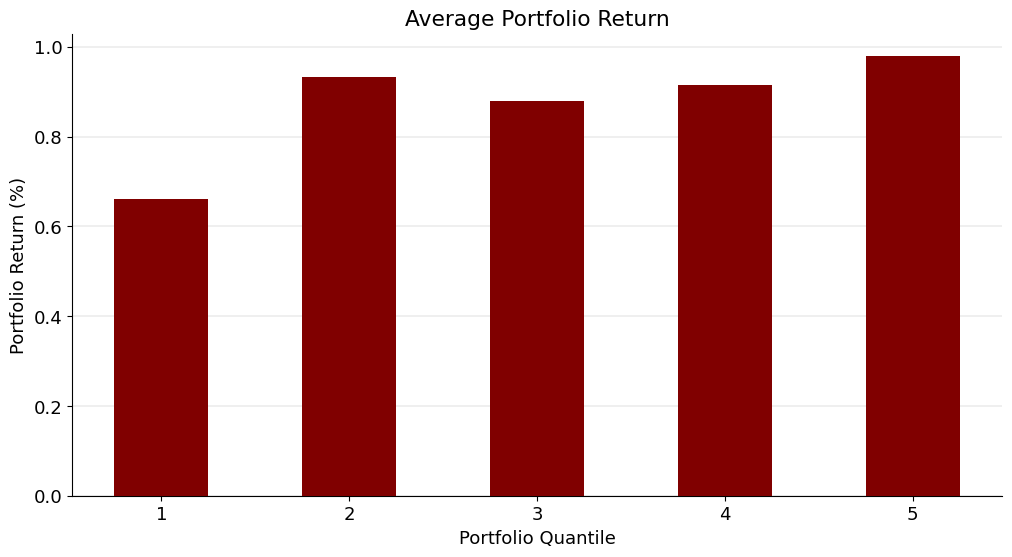

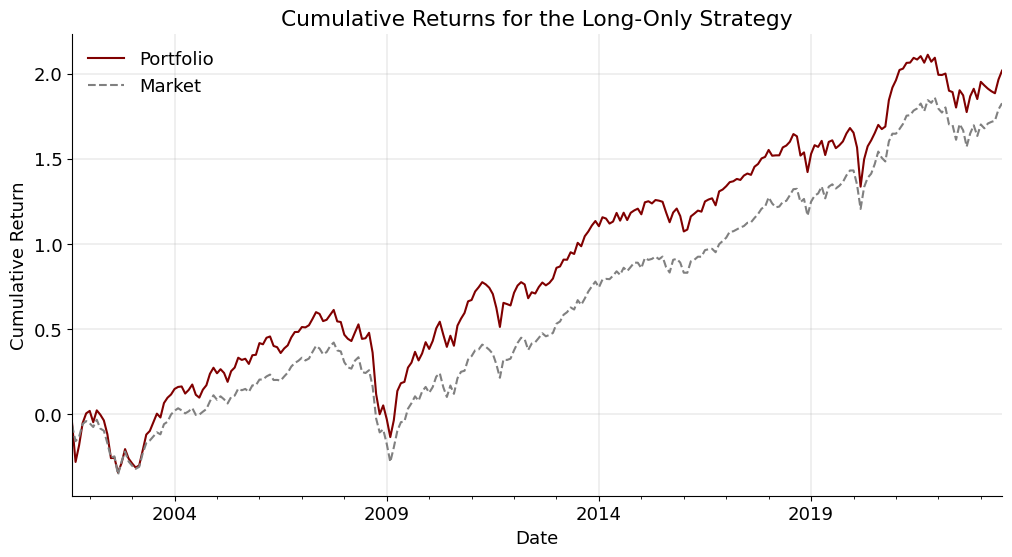

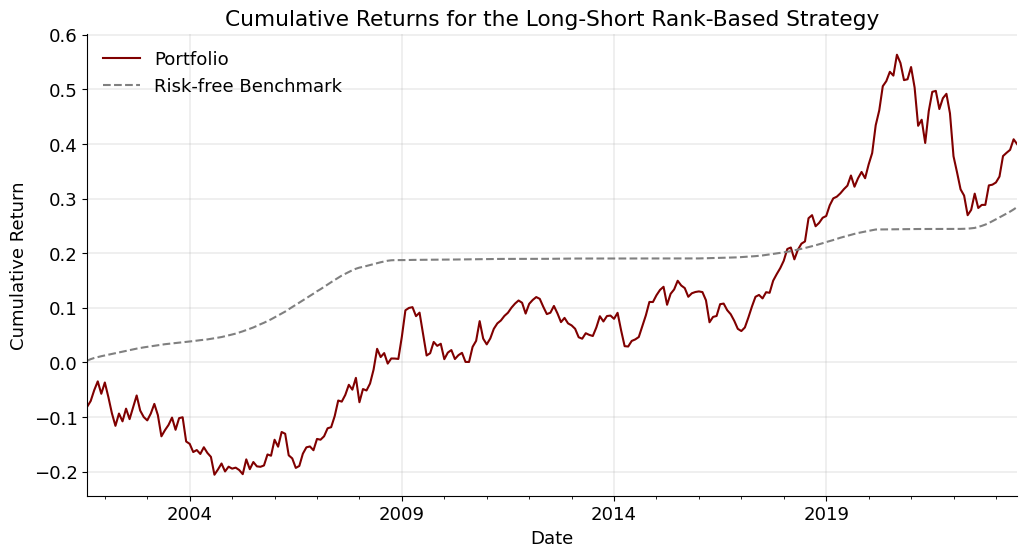

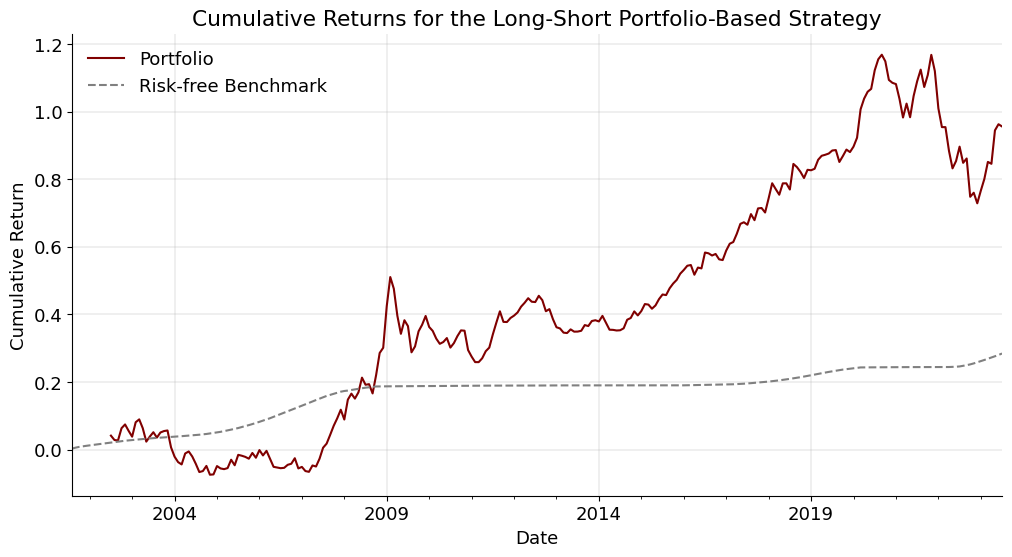

In [32]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [33]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   264.0  0.009376  0.057987 -0.216044 -0.021138  0.013945   
retP_rank_longshort  264.0  0.000643  0.020264 -0.081214 -0.010898  0.002774   
retF_vw              253.0  0.003196  0.030309 -0.109484 -0.015405  0.002339   
mktrf                264.0  0.006891  0.045259 -0.172300 -0.018425  0.012300   
smb                  264.0  0.001802  0.026613 -0.082800 -0.015075  0.001750   
hml                  264.0 -0.000172  0.031180 -0.138700 -0.016775 -0.001350   

                          75%       max  
retP_rank_longonly   0.044968  0.187223  
retP_rank_longshort  0.012165  0.060030  
retF_vw              0.019391  0.131029  
mktrf                0.032625  0.136500  
smb                  0.018900  0.071300  
hml                  0.015325  0.127500  


In [34]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)        (2)      (3)       (4)        (5)       (6)    
----------------------------------------------------------------------------
const          0.0041**   -0.0004   0.0012   0.0031**   -0.0001   0.0006    
               (0.0019)   (0.0011)  (0.0013) (0.0012)   (0.0005)  (0.0009)  
mktrf          -0.1180*** 1.1919*** -0.0068  -0.0401    1.0590*** 0.0125    
               (0.0421)   (0.0236)  (0.0276) (0.0288)   (0.0107)  (0.0212)  
hml                                          -0.7428*** -0.0335** -0.4629***
                                             (0.0403)   (0.0150)  (0.0296)  
smb                                          -0.0219    0.6416*** 0.1238*** 
                                             (0.

In [ ]:
_STRATEGY_DIR = 'C:/Users/natha/Documents/Python/QPM/Final_Project/Strategy'

if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))